# Add Folders to Path

In [1]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add EllipticOECS folder to current working path in order to access the functions
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/TRA")

CPU times: user 200 µs, sys: 150 µs, total: 350 µs
Wall time: 255 µs


In [2]:
# Suppress numba warnings arising from computation falling back into object mode.
from numba.core.errors import NumbaDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)

# Import Data

In [3]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../data/ABC/ABC_steady.mat')

U = mat_file['u']
V = mat_file['v']
W = mat_file['w']
x = mat_file['x']
y = mat_file['y']
z = mat_file['z']

CPU times: user 78.9 ms, sys: 83.3 ms, total: 162 ms
Wall time: 161 ms


# Data/Parameters for Dynamical System

In [4]:
import numpy as np

# number of cores to be used for parallel computing
Ncores = 18

# periodic boundary conditions
periodic_x = True
periodic_y = True
periodic_z = True
periodic = [periodic_x, periodic_y, periodic_z]

# unsteady velocity field
bool_unsteady = False

## compute meshgrid of dataset
X, Y, Z = np.meshgrid(x, y, z)

## resolution of meshgrid
dx_data = X[0,1,0]-X[0,0,0]
dy_data = Y[1,0,0]-Y[0,0,0]
dz_data = Z[0,0,1]-Z[0,0,0]

delta = [dx_data, dy_data, dz_data]

# Spatio-Temporal Domain of Dynamical System

In [5]:
%%time
from math import pi

# Time
t0 = 0
tN = 0.1
dt = 0.01

# store time in array
time = np.arange(t0, tN+dt, dt)

lenT = 1

# domain boundary (in degrees)
xmin = 0
xmax = 2*pi
ymin = 0
ymax = 2*pi
zmin = 0
zmax = 2*pi

# spacing of meshgrid (in degrees)
dx = 0.025
dy = 0.025
dz = 0.025

x_domain = np.linspace(xmin, xmax, int((xmax-xmin)/dx), endpoint = True)
y_domain = np.linspace(ymin, ymax, int((ymax-ymin)/dy), endpoint = True)
z_domain = np.linspace(ymin, ymax, int((zmax-zmin)/dz), endpoint = True)

X_domain, Y_domain, Z_domain = np.meshgrid(x_domain, y_domain, z_domain)

CPU times: user 94.8 ms, sys: 86.7 ms, total: 182 ms
Wall time: 180 ms


# Interpolate Velocity

In order to evaluate the velocity field at arbitrary locations and times, we must interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". In order to favour a smooth velocity field, we interpolate the velocity field in space using a cubic interpolant. 

In [6]:
%%time
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_steady

# Interpolate velocity data using linear spatial interpolation
Interpolant = interpolant_steady(X, Y, Z, U, V, W)

CPU times: user 54.5 ms, sys: 21.9 ms, total: 76.4 ms
Wall time: 75.2 ms


# Trajectory Rotation Average ($ \mathrm{\overline{TRA}}$)

In [7]:
%%time
# Import package for computing trajectories/velocity
from ipynb.fs.defs.integration_dFdt import integration_dFdt

# Import package for progress bar
from tqdm.notebook import tqdm

# Import package for parallel computing
from joblib import Parallel, delayed

# Import package for TRA
from ipynb.fs.defs.TRA import _TRA

def parallel_TRA(i):
    
    TRA_parallel = X_domain[0,0,:].copy()*np.nan
    
    for j in range(X_domain.shape[1]):
        
        # set initial condition
        x = np.array([X_domain[i, j, 0], Y_domain[i, j, 0], 0])
    
        # compute trajectory/velocity
        Fmap, dFdt = integration_dFdt(time, x, X, Y, Z, Interpolant, periodic, bool_unsteady)
        
        TRA_parallel[j] = _TRA(lenT, dFdt)
        
    return TRA_parallel

TRA = np.array(Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_TRA)(i) for i in tqdm(range(X_domain.shape[0]))))

  0%|          | 0/251 [00:00<?, ?it/s]

CPU times: user 1.83 s, sys: 561 ms, total: 2.39 s
Wall time: 2min 12s


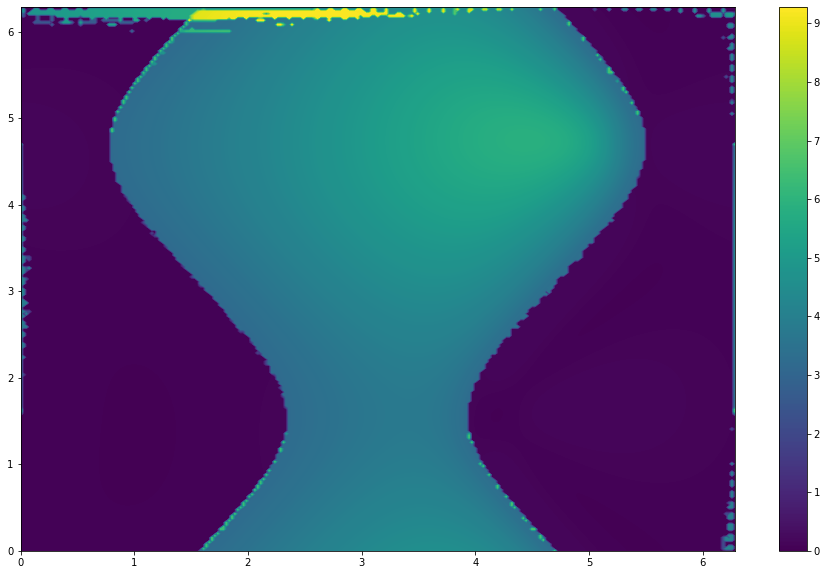

In [8]:
# import plotting libraries
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (16, 10))
ax = plt.axes()
cax = ax.contourf(X_domain[:,:,0], Y_domain[:,:,0], TRA, levels = 400)
plt.colorbar(cax, ticks = np.arange(0, 10, 1))
plt.show()